In [ ]:
!sinfo -O Nodehost,Gres:.30,GresUsed:.45
!salloc -N 1 --cpus-per-task=4 -p CS177h --gres=gpu:TeslaM4024GB:1
!salloc -N 1 --cpus-per-task=8 -p CS177h --gres=gpu:TeslaM4024GB:2
!salloc -N 1 --cpus-per-task=12 -p CS177h --gres=gpu:TeslaM4024GB:3
!salloc -N 1 --cpus-per-task=16 -p CS177h --gres=gpu:TeslaM4024GB:4
!jupyter-lab --no-brows --ip=0.0.0.0 --port=7774 

In [ ]:
%pip install fair-esm
%conda install biopython

In [1]:
!nvidia-smi

Mon Oct 31 19:05:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      On   | 00000000:02:00.0 Off |                    0 |
| N/A   28C    P8    28W / 250W |      0MiB / 22945MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      On   | 00000000:03:00.0 Off |                    0 |
| N/A   

In [ ]:
import sys
sys.path.append("/public/home/cs177h/lianyh/perl5/project")

from tqdm import tqdm
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

import esm

DATASET_PATH = Path() / "perl5" / "project" / "dataset" / "CASP14_fm"
MODEL_PATH = Path() / "perl5" / "project" / "model"
EMBDEDDINGS_PATH = Path() / "perl5" / "project" / "embdeddings"
TRANSFORMER_PATH = Path() / "perl5" / "project" / "esm_msa1b_t12_100M_UR50S.pt"

# hyperparameters
MAX_DEPTH = 256
EPOCHES = 50
LEARNING_RATE = 1e-4

## Explore data

### `.a3m` MSA

In [2]:
from dataset import read_msa

In [3]:
msa = read_msa(DATASET_PATH / "train" / "T1024-D1_aug_fm.a3m")
msa[:5]

[('T1024-D1:',
  'KEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPT'),
 ('3799131 len:525',
  'KGLWALAANTGERFGYTMLAVF---LLYLQANFHYEAGLASTIYSTFLML----VYFLPVIGGIAADRFGFGKMVTTGIFIMFIGYLL-LSIPMGGDYMAIIAMLALILVSLGTGLF--KGNLQVMAPQYADKRDSGFSLFYMAINIGAMFAPTIMDWYYHFAFAVACVSLIVSILIYYFTSSTYN-------'),
 ('tr|A0A0R1VVR4|A0A0R1VVR4_9LACO Major facilitator superfamily permease OS=Lactobacillus ghanensis DSM 18630 GN=FC89_GL000394 PE=4 SV=1',
  'ENIMK--KNLPILLA-SMLVNMGIGLIMPITTLFLHNRLHQTLVTVLMGF-SLAMVLGNLLGGWLFDHWKVKPTHYLGGLLVWLNLTLLIIFPI------WPLY-TILVIGYGFGL----GILNSAIAAHQKKSPNLFTNAYWLANLGMGLATF----NIRWVFSVALFIFIVTLLVVFFHE-----------'),
 ('8253022 len:434',
  'ANFILLV------LG-QGISLFGNTMLFAMSMWVLDETASSTTFATVLAISVIPTILISPFGGVMADRVSKRAMMVISGIVTLLATVF---FALSG----FNILIAIMQVVLAVLDAMETPVVQSAGRESSTDLRRGAAIINQVQQLSQLLPSFLGGVGIRPMMLITAACLMSAAMVECFIRLAKPNQ-----'),
 ('7

### Read MSAs

read MSA from `.a3m` files

In [4]:
from dataset import read_msa_data

In [10]:
msa_data_train, _ = read_msa_data(root = DATASET_PATH, is_train = True)
msa_data_test, _ = read_msa_data(root = DATASET_PATH, is_train = False)

In [12]:
print(f"# of train MSAs: {len(msa_data_train)}")
print(f"> max MSA depth in train set: {max(len(msa['msa']) for _, msa in msa_data_train.items())}" )
print(f"> max sequence length in train set: {max(len(msa['msa'][0][1]) for _, msa in msa_data_train.items())}" )

print(f"# of test MSAs: {len(msa_data_test)}")
print(f"> max MSA depth in test set: {max(len(msa['msa']) for _, msa in msa_data_test.items())}" )
print(f"> max sequence length in test set: {max(len(msa['msa'][0][1]) for _, msa in msa_data_test.items())}" )

# of train MSAs: 2660
> max MSA depth in train set: 32494
> max sequence length in train set: 583
# of test MSAs: 190
> max MSA depth in test set: 21298
> max sequence length in test set: 583


Sort MSAs by scores:

In [13]:
def print_top_scored_msas(msa_data, top_k = 10, bot_k = 5) :
    msa_scores = sorted([(msa['score'], msa_name) for msa_name, msa in msa_data.items()], reverse = True)
    for _, msa_name in msa_scores[:top_k] :
        msa = msa_data[msa_name]
        print(f"MSA {msa_name} has { len(msa['msa']) } sequences of length { len(msa['msa'][0][1]) }, scored {msa['score']:.3f}")
    print("......")
    for _, msa_name in msa_scores[-bot_k:] :
        msa = msa_data[msa_name]
        print(f"MSA {msa_name} has { len(msa['msa']) } sequences of length { len(msa['msa'][0][1]) }, scored {msa['score']:.3f}")

In [14]:
print_top_scored_msas(msa_data_train)

MSA T1070-D2_rosetta_fm has 10403 sequences of length 101, scored 99.752
MSA T1070-D2_our_fm has 4277 sequences of length 101, scored 99.752
MSA T1070-D2_original_fm has 8885 sequences of length 101, scored 99.752
MSA T1070-D2_meta_fm has 6439 sequences of length 101, scored 99.505
MSA T1070-D2_deduplicated_fm has 2155 sequences of length 101, scored 99.505
MSA T1070-D2_cov50_fm has 1956 sequences of length 101, scored 99.505
MSA T1101-D1_rand22_fm has 204 sequences of length 83, scored 99.097
MSA T1065s2-D1_original_fm has 8868 sequences of length 98, scored 98.980
MSA T1101-D1_rand9_fm has 203 sequences of length 83, scored 98.795
MSA T1101-D1_rand19_fm has 203 sequences of length 83, scored 98.795
......
MSA T1026-D1_rand9_fm has 201 sequences of length 146, scored 15.925
MSA T1026-D1_rand15_fm has 206 sequences of length 146, scored 15.925
MSA T1026-D1_rand7_fm has 200 sequences of length 146, scored 15.755
MSA T1043-D1_rand3_fm has 204 sequences of length 148, scored 15.370
MSA T1

In [15]:
print_top_scored_msas(msa_data_test)

MSA T1070-D2_base_fm has 4808 sequences of length 101, scored 99.752
MSA T1101-D1_rand18_fm has 202 sequences of length 83, scored 99.398
MSA T1065s2-D1_base_fm has 4543 sequences of length 98, scored 99.235
MSA T1046s2-D1_rosetta_fm has 52 sequences of length 141, scored 98.935
MSA T1070-D4_base_fm has 398 sequences of length 68, scored 98.162
MSA T1091-D4_our_fm has 4888 sequences of length 112, scored 97.990
MSA T1046s1-D1_rosetta_fm has 44 sequences of length 72, scored 97.915
MSA T1101-D1_rand13_fm has 203 sequences of length 83, scored 97.892
MSA T1052-D3_original_fm has 3201 sequences of length 80, scored 97.812
MSA T1089-D1_meta_fm has 9576 sequences of length 377, scored 97.810
......
MSA T1026-D1_rand13_fm has 202 sequences of length 146, scored 16.780
MSA T1056-D1_rand15_fm has 203 sequences of length 169, scored 16.273
MSA T1038-D1_rand6_fm has 207 sequences of length 114, scored 16.230
MSA T1090-D1_rand6_fm has 201 sequences of length 189, scored 15.475
MSA T1043-D1_rand1_

In [16]:
msa = msa_data_test["T1084-D1_our_fm"]['msa']
msa_sequences = [sequence for _, sequence in msa]
msa_sequences[:5]

['AHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH',
 '----IEHHHKAAEHHEHAAKHHHAAAEHHQNGDHEKASHHAHAAHGHALHAEHHASEAAKHHANEHG----',
 '-HKGAEHHHKAAEHHEHAARHHREAAKHYETGNHEKAAHHAHVAHGHHLHARHHAEEATKHHASEHG----',
 '-HKGAEHHKKAAEHHELAAKHHREAAKHHEAGSHEKGAHHSEIAAGHGLHATYHTEEATKHHAEEHTG---',
 '--QAAEHHRKAAEHHEHAARHHEEAAEHHEAGKHETAAHHAHLARAHHEVATHHAVEAAKAHLEQHG----']

In [17]:
print(f"# of sequences (depth) : { len(msa_sequences) }")
print(f"# of protetins in a sequence: { len(msa_sequences[0]) }")

# of sequences (depth) : 2823
# of protetins in a sequence: 71


In [20]:
def same_length(msa_data):
    return all(all([len(sequence) == len(msa['msa'][0]) for sequence in msa['msa']]) for msa in msa_data.values())

if same_length(msa_data_test) and same_length(msa_data_train):
    print("All sequences in an MSA share the same number of protetins.")

All sequences in an MSA share the same number of protetins.


### Subsampling MSA

Subsampling MSA = swallowing MSA depth = decreasing # of sequences in an MSA

#### HH Filter

We can see the number of sequences (also called MSA depth) of MSAs varies and some are very deep. Furthermore, the MSA Transformer only supports maximum MSA depth $\leq 1024$. 

We try to cut the number of sequences of deeper MSAs to 256 each. A simple approach is to intercept the first 256 sequences. However, let's try the method called **HH Filter** with the `-diff 256` parameter, which can extract a representative set (256 or more, usually close to 256) of the sequences from an alignment. If more than 256 sequences are returned we apply the Diversity Maximizing strategy on the HHFilter output.

In [ ]:
%conda install -c conda-forge -c bioconda hhsuite 

You can run HHFilter in command line like `hhfilter -i <INTPUT> -o <OUTPUT> [options] `. See https://manpages.ubuntu.com/manpages/bionic/man1/hhfilter.1.html.



In [21]:
!hhfilter -i perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m -o perl5/project/dataset/CASP14_fm/test_filtered/T1084-D1_our_fm.a3m -diff 256 -v 3

- 15:47:19.878 INFO: Input file = perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m

- 15:47:19.878 INFO: Output file = perl5/project/dataset/CASP14_fm/test_filtered/T1084-D1_our_fm.a3m

- 15:47:19.990 DEBUG: Read perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m with 2823 sequences

- 15:47:19.990 DEBUG: Single sequence in file perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m contains only 71 match_states! Switching to option -M first
 seq= AHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH

- 15:47:19.993 DEBUG: Alignment in perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m contains 71 match states

- 15:47:19.993 DEBUG: Using the Gonnet matrix

- 15:47:19.993 DEBUG: sequence identity = 17.3066 %; entropy per column = 3.93717 bits (out of 4.18529); mutual information = 0.248121 bits

- 15:47:20.001 DEBUG: 281 out of 2823 sequences passed filter (
- 15:47:20.001 DEBUG: up to 25% position-dependent max pairwise sequence identity)



You can also do this via:

In [5]:
from subsampling import hh_filter
hh_filter("T1084-D1_our_fm.a3m", DATASET_PATH / "test", DATASET_PATH / "test_filtered", diff=256, verbose=2)

- 15:53:50.158 INFO: Input file = perl5/project/dataset/CASP14_fm/test/T1084-D1_our_fm.a3m

- 15:53:50.158 INFO: Output file = perl5/project/dataset/CASP14_fm/test_filtered/T1084-D1_our_fm.a3m



You will see 281 (close to 256) sequences are filtered out of all 2823 sequences. Now let's apply for all:

In [6]:
from subsampling import filter_msa_data

In [18]:
filter_msa_data(msa_data_train, root = DATASET_PATH, is_train = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2660/2660 [01:30<00:00, 29.43it/s]


In [19]:
filter_msa_data(msa_data_test, root = DATASET_PATH, is_train = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:15<00:00, 12.24it/s]


You will see MSA depths are much better but some are still $>256$:

In [22]:
msa_data_train, _ = read_msa_data(is_train = True, is_filtered = True)
print_top_scored_msas(msa_data_train) 

MSA T1070-D2_rosetta_fm has 267 sequences of length 101, scored 99.752
MSA T1070-D2_our_fm has 285 sequences of length 101, scored 99.752
MSA T1070-D2_original_fm has 256 sequences of length 101, scored 99.752
MSA T1070-D2_meta_fm has 485 sequences of length 101, scored 99.505
MSA T1070-D2_deduplicated_fm has 437 sequences of length 101, scored 99.505
MSA T1070-D2_cov50_fm has 388 sequences of length 101, scored 99.505
MSA T1101-D1_rand22_fm has 204 sequences of length 83, scored 99.097
MSA T1065s2-D1_original_fm has 314 sequences of length 98, scored 98.980
MSA T1101-D1_rand9_fm has 203 sequences of length 83, scored 98.795
MSA T1101-D1_rand19_fm has 203 sequences of length 83, scored 98.795
......
MSA T1026-D1_rand9_fm has 201 sequences of length 146, scored 15.925
MSA T1026-D1_rand15_fm has 206 sequences of length 146, scored 15.925
MSA T1026-D1_rand7_fm has 200 sequences of length 146, scored 15.755
MSA T1043-D1_rand3_fm has 204 sequences of length 148, scored 15.370
MSA T1028-D1_r

In [23]:
msa_data_test, _ = read_msa_data(is_train = False, is_filtered = True)
print_top_scored_msas(msa_data_test)

MSA T1070-D2_base_fm has 420 sequences of length 101, scored 99.752
MSA T1101-D1_rand18_fm has 202 sequences of length 83, scored 99.398
MSA T1065s2-D1_base_fm has 331 sequences of length 98, scored 99.235
MSA T1046s2-D1_rosetta_fm has 52 sequences of length 141, scored 98.935
MSA T1070-D4_base_fm has 227 sequences of length 68, scored 98.162
MSA T1091-D4_our_fm has 556 sequences of length 112, scored 97.990
MSA T1046s1-D1_rosetta_fm has 44 sequences of length 72, scored 97.915
MSA T1101-D1_rand13_fm has 203 sequences of length 83, scored 97.892
MSA T1052-D3_original_fm has 273 sequences of length 80, scored 97.812
MSA T1089-D1_meta_fm has 455 sequences of length 377, scored 97.810
......
MSA T1026-D1_rand13_fm has 202 sequences of length 146, scored 16.780
MSA T1056-D1_rand15_fm has 203 sequences of length 169, scored 16.273
MSA T1038-D1_rand6_fm has 207 sequences of length 114, scored 16.230
MSA T1090-D1_rand6_fm has 201 sequences of length 189, scored 15.475
MSA T1043-D1_rand1_fm ha

#### Diversity Maxmizing

Diversity Maximizing is a greedy strategy which starts from the reference and adds the sequence with highest average hamming distance to current set of sequences. Hence we can cut each MSA to at most 256 sequences.

In [7]:
from subsampling import greedy_subsampling

For example:

In [8]:
msa = read_msa(DATASET_PATH / "test_filtered" / "T1084-D1_our_fm.a3m")
print(f"before subsampling: { len(msa) }")

before subsampling: 281


In [9]:
msa_subsampled = greedy_subsampling(msa)
print(f"after subsampling: { len(msa_subsampled) }")

after subsampling: 256


Then we apply for all MSAs:

In [10]:
from subsampling import subsampling_msa_data

In [28]:
msa_data_train = subsampling_msa_data(msa_data_train)
print_top_scored_msas(msa_data_train)

MSA T1070-D2_rosetta_fm has 256 sequences of length 101, scored 99.752
MSA T1070-D2_our_fm has 256 sequences of length 101, scored 99.752
MSA T1070-D2_original_fm has 256 sequences of length 101, scored 99.752
MSA T1070-D2_meta_fm has 256 sequences of length 101, scored 99.505
MSA T1070-D2_deduplicated_fm has 256 sequences of length 101, scored 99.505
MSA T1070-D2_cov50_fm has 256 sequences of length 101, scored 99.505
MSA T1101-D1_rand22_fm has 204 sequences of length 83, scored 99.097
MSA T1065s2-D1_original_fm has 256 sequences of length 98, scored 98.980
MSA T1101-D1_rand9_fm has 203 sequences of length 83, scored 98.795
MSA T1101-D1_rand19_fm has 203 sequences of length 83, scored 98.795
......
MSA T1026-D1_rand9_fm has 201 sequences of length 146, scored 15.925
MSA T1026-D1_rand15_fm has 206 sequences of length 146, scored 15.925
MSA T1026-D1_rand7_fm has 200 sequences of length 146, scored 15.755
MSA T1043-D1_rand3_fm has 204 sequences of length 148, scored 15.370
MSA T1028-D1_r

In [29]:
msa_data_test = subsampling_msa_data(msa_data_test)
print_top_scored_msas(msa_data_test)

MSA T1070-D2_base_fm has 256 sequences of length 101, scored 99.752
MSA T1101-D1_rand18_fm has 202 sequences of length 83, scored 99.398
MSA T1065s2-D1_base_fm has 256 sequences of length 98, scored 99.235
MSA T1046s2-D1_rosetta_fm has 52 sequences of length 141, scored 98.935
MSA T1070-D4_base_fm has 227 sequences of length 68, scored 98.162
MSA T1091-D4_our_fm has 256 sequences of length 112, scored 97.990
MSA T1046s1-D1_rosetta_fm has 44 sequences of length 72, scored 97.915
MSA T1101-D1_rand13_fm has 203 sequences of length 83, scored 97.892
MSA T1052-D3_original_fm has 256 sequences of length 80, scored 97.812
MSA T1089-D1_meta_fm has 256 sequences of length 377, scored 97.810
......
MSA T1026-D1_rand13_fm has 202 sequences of length 146, scored 16.780
MSA T1056-D1_rand15_fm has 203 sequences of length 169, scored 16.273
MSA T1038-D1_rand6_fm has 207 sequences of length 114, scored 16.230
MSA T1090-D1_rand6_fm has 201 sequences of length 189, scored 15.475
MSA T1043-D1_rand1_fm ha

## Explore Model

In [2]:
msa_data_train, _ = read_msa_data(is_train = True, is_filtered = True)
msa_data_train = subsampling_msa_data(msa_data_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2660/2660 [00:39<00:00, 66.53it/s]


In [3]:
msa_data_test, _ = read_msa_data(is_train = False, is_filtered = True)
msa_data_test = subsampling_msa_data(msa_data_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 27.93it/s]


In [19]:
torch.cuda.device_count()

1

load MSA Transformer model

In [14]:
DOWNLOAD_TRANSFORMER = False
if DOWNLOAD_TRANSFORMER :
    msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
else :
    msa_transformer, msa_alphabet = esm.pretrained.load_model_and_alphabet_local(TRANSFORMER_PATH)

# USE_PARALLEL = torch.cuda.device_count() > 1
# # USE_PARALLEL = False
# if USE_PARALLEL :
#     msa_transformer = torch.nn.DataParallel(msa_transformer)
    
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()

In [21]:
print(f"alphabet size: {len(msa_alphabet)}")
print(f"padding token: {msa_alphabet.padding_idx}")
print(f"begin of sequence token : {msa_alphabet.cls_idx}")
print(f"end of sequence token (not used here) : {msa_alphabet.eos_idx}")

alphabet size: 33
padding token: 1
begin of sequence token : 0
end of sequence token (not used here) : 2


In [15]:
msa_transformer

MSATransformer(
  (embed_tokens): Embedding(33, 768, padding_idx=1)
  (dropout_module): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): AxialTransformerLayer(
      (row_self_attention): NormalizedResidualBlock(
        (layer): RowSelfAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (dropout_module): Dropout(p=0.1, inplace=False)
        )
        (dropout_module): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (column_self_attention): NormalizedResidualBlock(
        (layer): ColumnSelfAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=Tr

In [76]:
from dataset import read_msa
msa_data = [
    read_msa(DATASET_PATH / "train_filtered" / "T1024-D1_aug_fm.a3m"),
    read_msa(DATASET_PATH / "train_filtered" / "T1024-D1_base_fm.a3m"),
    #read_msa(DATASET_PATH / "train_filtered" / "T1101-D2_rand22_fm.a3m")
]

msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa_data)
print(msa_batch_tokens.shape, msa_batch_tokens.dtype)   # Should be a 3D tensor with dtype torch.int64.

torch.Size([2, 267, 194]) torch.int64


In [22]:
print(msa_batch_tokens)
# 0: beginning of sequence
# 1: empty
# 30: -

tensor([[[ 0, 15,  9,  ..., 15, 14, 11],
         [ 0, 15,  6,  ..., 30, 30, 30],
         [ 0,  9, 17,  ..., 30, 30, 30],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 0, 15,  9,  ..., 15, 14, 11],
         [ 0, 30, 30,  ..., 30, 30, 30],
         [ 0, 30, 30,  ..., 30, 11, 30],
         ...,
         [ 0, 30, 30,  ..., 14, 14, 30],
         [ 0, 30, 30,  ..., 10,  5, 30],
         [ 0, 30, 30,  ..., 30, 30, 30]]])


In [28]:
print(f"max MSA depth (# of sequences): { msa_batch_tokens.shape[1] }")
print(f"max length of each sequence: { msa_batch_tokens.shape[2]-1 }")

max MSA depth (# of sequences): 256
max length of each sequence: 193


In [29]:
print(f"# of model layers: {len((msa_transformer.module if USE_PARALLEL else msa_transformer).layers)}")
print(f"model embedding dimension: {(msa_transformer.module if USE_PARALLEL else msa_transformer).layers[0].embedding_dim}")

# of model layers: 12
model embedding dimension: 768


Run model

In [77]:
msa_transformer.eval()
with torch.no_grad():
    torch.cuda.empty_cache()
    results = msa_transformer(msa_batch_tokens.cuda(non_blocking = True), repr_layers=[12])
    #results = msa_transformer(msa_batch_tokens.cuda(), repr_layers=[12], need_head_weights = True)

In [62]:
embeddings = results['representations'][12][:, 0, 1:, :]
embeddings.shape

torch.Size([3, 214, 768])

In [78]:
print(msa_batch_tokens[0][0][1:])

print(torch.argmax(results['logits'][0][0][1:], axis = 1))

tensor([15,  9, 18, 22, 17,  4, 13, 15, 17,  4, 16,  4, 10,  4,  6, 12,  7, 18,
         4,  6,  5, 18,  8, 19,  6, 11,  7, 18,  8,  8, 20, 11, 12, 19, 19, 17,
        16, 19,  4,  6,  8,  5, 12, 11,  6, 12,  4,  4,  5,  4,  8,  5,  7,  5,
        11, 18,  7,  5,  6, 12,  4,  5,  6, 18, 18,  5, 13, 10, 17,  6, 10, 15,
        14,  7, 20,  7, 18,  6, 11, 12, 12, 16,  4,  4,  6,  5,  5,  4,  5, 12,
         5,  8, 17,  4, 14,  6, 21,  7, 17, 14, 22,  8, 11, 18, 12,  5, 18,  4,
         4, 12,  8, 18,  6, 19, 17, 18,  7, 12, 11,  5,  6, 17,  5, 20, 12, 12,
        13,  5,  8, 17,  5,  9, 17, 10, 15,  7,  7, 18, 20,  4, 13, 19, 22,  5,
        16, 17,  4,  8,  7, 12,  4,  6,  5,  5,  4,  6,  5, 22,  4, 18, 10, 14,
         5, 18,  9,  5,  4,  4,  7, 12,  4,  4,  4, 11,  7,  4,  7,  8, 18, 18,
         4, 11, 11, 18,  7, 20, 11,  9, 11, 18, 15, 14, 11])
tensor([15,  9, 18, 22, 17,  4, 13, 15, 17,  4, 16,  4, 10,  4,  6, 12,  7, 18,
         4,  6,  5, 18,  8, 19,  6, 11,  7, 18,  8,  8, 20,

## Implement Dataset

In [9]:
from dataset import MSAScoreDataset

In [10]:
train_dataset = MSAScoreDataset(root = DATASET_PATH, is_train = True)
train_dataset.summary()

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1876/2660 [00:27<00:16, 46.93it/s]

In [ ]:
test_dataset = MSAScoreDataset(root = DATASET_PATH, is_train = False)
test_dataset.summary()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.54it/s]

Dataset has 190 MSAs:
> MSA T1024-D1_meta_fm has 256 sequences of length 193, scored 96.243
> MSA T1024-D1_rand10_fm has 206 sequences of length 193, scored 56.865
> MSA T1024-D2_original_fm has 256 sequences of length 198, scored 95.580
> MSA T1024-D2_rand13_fm has 203 sequences of length 198, scored 92.803
> MSA T1025-D1_our_fm has 256 sequences of length 257, scored 92.315
> MSA T1025-D1_rand1_fm has 202 sequences of length 257, scored 57.297
> MSA T1026-D1_rand13_fm has 202 sequences of length 146, scored 16.780
> MSA T1026-D1_rosetta_fm has 19 sequences of length 146, scored 93.325
> MSA T1027-D1_cov50_fm has 256 sequences of length 99, scored 65.153
> MSA T1027-D1_rand18_fm has 203 sequences of length 99, scored 26.513
......
> MSA T1099-D1_cov50_fm has 256 sequences of length 178, scored 27.527
> MSA T1099-D1_rosetta_fm has 8 sequences of length 178, scored 80.058
> MSA T1100-D1_rand13_fm has 200 sequences of length 169, scored 60.800
> MSA T1100-D1_rosetta_fm has 256 sequences 

## Implement Model

In [ ]:
class MSAPredictor(nn.Module):
    def __init__(self, msa_transformer_path = TRANSFORMER_PATH):
        super(MSAPredictor, self).__init__()
        
        if msa_transformer_path:
            self.encoder, msa_alphabet = esm.pretrained.load_model_and_alphabet_local(msa_transformer_path)
        else :
            self.encoder, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
        
        self.encoder = self.encoder.eval()
        self.batch_converter = msa_alphabet.get_batch_converter()

        # Freeze parameters of MSATransformer
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Regressor module (to be tested)
        # self.conv1 = nn.Conv2d(1, 6, 5)
        # self.pool = nn.MaxPool2d(3, 3)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(25232, 2048)
        # self.fc2 = nn.Linear(2048, 512)
        # self.fc3 = nn.Linear(512, 1)
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        seq_length = [list(x[i, 0]).index(1) if 1 in x[i, 0] else x.size(2) for i in range(x.size(0))]
        
        self.encoder
        embeddings = []
        with torch.no_grad():
            for i in range(x.size(0)) :
                # Remove sequence paddings
                xi = x[i:i+1, :, :seq_length[i]]
                # 1 x NUM_SEQ x 1+SEQ_LEN

                # xx = xx[:, :list(x[i, :, 0]).index(1), :] if 1 in x[i, :, 0] else xx

                xi = self.encoder(xi, repr_layers=[12])["representations"][12][:, 0, 1:, :]
                # 1 x SEQ_LEN x 768

                xi = torch.mean(xi, dim = 1)
                # 1 x 768
                embeddings.append(xi)
                
        x = torch.vstack(embeddings)
        # BATHCH_SIZE x 768

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))

        # x = torch.flatten(x, 1)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # x = torch.sigmoid(self.fc3(x))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
torch.cuda.device_count()

4

In [ ]:
model = MSAPredictor().cuda()
batch_converter = model.batch_converter

NUM_GPU = torch.cuda.device_count()
USE_PARALLEL = NUM_GPU > 1
if USE_PARALLEL :
    model = torch.nn.DataParallel(model)

model

DataParallel(
  (module): MSAPredictor(
    (encoder): MSATransformer(
      (embed_tokens): Embedding(33, 768, padding_idx=1)
      (dropout_module): Dropout(p=0.1, inplace=False)
      (layers): ModuleList(
        (0): AxialTransformerLayer(
          (row_self_attention): NormalizedResidualBlock(
            (layer): RowSelfAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout_module): Dropout(p=0.1, inplace=False)
            )
            (dropout_module): Dropout(p=0.1, inplace=False)
            (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (column_self_attention): NormalizedResidualBlock(
            (layer): ColumnSelfAttention(
              (k_pr

In [ ]:
batch_collate_fn = lambda batch: {'msa': batch_converter([msa['msa'] for msa in batch])[2], 'score': torch.Tensor([[msa['score'] / 100.0] for msa in batch])}

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, collate_fn = batch_collate_fn, num_workers = NUM_GPU * 4, pin_memory = True, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 2, collate_fn = batch_collate_fn, shuffle = False)

In [ ]:
dataiter = iter(train_loader)
print(next(dataiter))

{'msa': tensor([[[ 0,  7,  8,  ...,  1,  1,  1],
         [ 0, 20,  8,  ...,  1,  1,  1],
         [ 0,  7,  8,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 0, 20, 18,  ...,  1,  1,  1],
         [ 0, 20, 12,  ...,  1,  1,  1],
         [ 0, 20, 20,  ...,  1,  1,  1],
         ...,
         [ 0, 30, 30,  ...,  1,  1,  1],
         [ 0, 30, 30,  ...,  1,  1,  1],
         [ 0, 30, 30,  ...,  1,  1,  1]],

        [[ 0, 10, 16,  ...,  1,  1,  1],
         [ 0, 10, 16,  ...,  1,  1,  1],
         [ 0, 10, 16,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        ...,

        [[ 0, 20, 12,  ...,  1,  1,  1],
         [ 0,  4, 16,  ...,  1,  1,  1],
         [ 0, 30, 30,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1, 

### Implement Train

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

model_name = "mean_256"
checkpoint_epoch = 11
if checkpoint_epoch > 0 :
    checkpoint = torch.load(MODEL_PATH / f"model_{model_name}_epoch{checkpoint_epoch}.pth")
    (model.module if USE_PARALLEL else model).load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"The {model_name} model loaded has been trained for {epoch} epoche(s), with {checkpoint['train_mse']} training loss, {checkpoint['valid_mse']} validation MSE and {checkpoint['test_acc']} test accuracy. ")
else :
    print(f"Start training {model_name} model from the 1st epoch.")

The mean_120 model loaded has been trained for 3 epoche(s), with 0.019078227395850016 training loss, 0.01769655714007585 validation MSE and 0.9473684210526315 test accuracy. 


In [ ]:
def calc_test_metric(model):
    model.eval()
    mse, correct, tot = 0.0, 0, 0
    with torch.no_grad():
        with tqdm(total = len(test_loader), ncols=80) as bar:
            for sample in test_loader :
                x, y = sample["msa"].cuda(non_blocking = True), sample["score"].cuda()
                pred = model(x)

                mse += torch.sum((y - pred) ** 2).item() 
                correct += torch.sum(torch.argmax(y) == torch.argmax(pred)).item()
                tot += 2

                bar.set_postfix({
                    "acc" : f"{correct / (tot // 2):.4f}",
                    "mse": f"{mse / tot:.4f}"
                })
                bar.update(1)
    
    return {'accuracy' : correct / (tot // 2), 'mse' : mse / tot}

In [ ]:
for epoch in range(checkpoint_epoch + 1, EPOCHES + 1):
    losses, tot = 0, 0
    
    model.train()
    with tqdm(total= len(train_loader), ncols=130) as bar:
        for batch, sample in enumerate(train_loader) :
            bar.set_description(f"[epoch#{epoch}/{EPOCHES}][{batch * BATCH_SIZE}/{len(train_dataset)}]")

            x, y = sample["msa"].cuda(non_blocking = True), sample["score"].cuda()
            pred = model(x)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()     
            loss.backward()
            optimizer.step()
            
            losses += loss.item() * x.size(0)
            tot += x.size(0)
            bar.set_postfix({
                "batch loss" : f"{loss.item():.5f}",
                "loss": f"{losses / tot:.5f}"
            })
            bar.update(1)

    test_metric =  calc_test_metric(model)
    train_mse, test_acc, valid_mse =  losses / tot, test_metric['accuracy'], test_metric['mse']
    torch.save({
        'epoch': epoch,
        'model_state_dict': (model.module if USE_PARALLEL else model).state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_mse': train_mse,
        'valid_mse': valid_mse,
        'test_acc': test_acc
    }, MODEL_PATH / f"model_{model_name}_epoch{epoch}.pth")

[epoch#3/50][1184/2660]:  44%|██████████████▉                   | 37/84 [22:26<28:21, 36.21s/it, batch loss=0.01386, loss=0.01908]

In [ ]:
# Baseline: output the one with more sequences
def calc_baseline_test_acc(test_dataset):
    correct = 0
    pairs = len(test_dataset) // 2
    for i in range(pairs) :
        msa1, msa2 = test_dataset[2*i], test_dataset[2*i+1]
        pred = len(msa1['msa']) > len(msa2['msa'])
        gt = msa1['score'] > msa2['score']
        if pred == gt : 
            correct += 1
        else :
            print(f"{msa1['name']} of {len(msa1['msa'])} sequences is scored {msa1['score']}.")
            print(f"{msa2['name']} of {len(msa2['msa'])} sequences is scored {msa2['score']}.")
            print("------------")
    return correct / pairs

T1026-D1_rand13_fm of 202 sequences is scored 16.78.
T1026-D1_rosetta_fm of 19 sequences is scored 93.325.
------------
T1030-D2_base_fm of 27 sequences is scored 91.177.
T1030-D2_original_fm of 256 sequences is scored 60.085.
------------
T1033-D1_base_fm of 11 sequences is scored 85.25.
T1033-D1_rand13_fm of 209 sequences is scored 36.0.
------------
T1036s1-D1_our_fm of 256 sequences is scored 36.192.
T1036s1-D1_rand19_fm of 200 sequences is scored 65.053.
------------
T1038-D1_base_fm of 110 sequences is scored 89.475.
T1038-D1_rand6_fm of 207 sequences is scored 16.23.
------------
T1038-D2_base_fm of 70 sequences is scored 91.778.
T1038-D2_rand13_fm of 200 sequences is scored 70.725.
------------
T1046s1-D1_rand13_fm of 204 sequences is scored 63.542.
T1046s1-D1_rosetta_fm of 44 sequences is scored 97.915.
------------
T1046s2-D1_rand1_fm of 201 sequences is scored 21.633.
T1046s2-D1_rosetta_fm of 52 sequences is scored 98.935.
------------
T1047s2-D2_rand16_fm of 204 sequences i

In [ ]:
def print_wrong_predictions(model):
    model.eval()
    mse, correct, tot = 0.0, 0, 0
    with torch.no_grad():
        with tqdm(total = len(test_loader), ncols=80, file=sys.stdout) as bar:
            for sample in test_loader :
                x, y = sample["msa"].cuda(non_blocking = True), sample["score"].cuda()
                pred = model(x)

                mse += torch.sum((y - pred) ** 2).item() 
                if torch.argmax(y) == torch.argmax(pred) :
                    correct += 1
                    for x, y_gt, y_pred in zip(x, y, pred) :
                        tqdm.write(f"{list(x[:, 0]).index(1) if 1 in x[:, 0] else 256:>4d}x{x.size(1):>4d} y_gt:{y_gt.item():.4f}  y_pred:{y_pred.item() * 120:.4f}")
                    tqdm.write("======")
                else :
                    for x, y_gt, y_pred in zip(x, y, pred) :
                        tqdm.write(f"{list(x[:, 0]).index(1) if 1 in x[:, 0] else 256:>4d}x{x.size(1):>4d} y_gt:{y_gt.item():.4f}  y_pred:{y_pred.item() * 120:.4f}")
                    tqdm.write("-------")
                tot += 2

                bar.set_postfix({
                    "acc" : f"{correct / (tot // 2):.4f}",
                    "mse": f"{mse / tot:.4f}"
                })
                bar.update(1)
    
    return {'accuracy' : correct / (tot // 2), 'mse' : mse / tot}

#print_wrong_predictions(model)

 256x 155 y_gt:85.7150  y_pred:86.6433                                          
 203x 155 y_gt:81.4950  y_pred:86.6760                                          
-------                                                                         
  27x 120 y_gt:91.1770  y_pred:64.8868                                          
 256x 120 y_gt:60.0850  y_pred:68.9962                                          
-------                                                                         
  11x 101 y_gt:85.2500  y_pred:56.1897                                          
 256x 101 y_gt:36.0000  y_pred:63.0460                                          
-------                                                                         
 27%|█████▏             | 26/95 [01:46<03:41,  3.21s/it, acc=0.8846, mse=0.0170]

100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


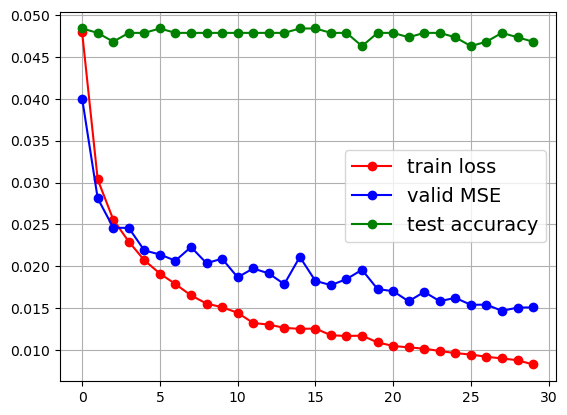

In [6]:
def plot_training_history(model_name = "mean_256", trained_epoches = 10):
    train_losses = []
    test_losses = []
    test_accs = []
    for epoch in tqdm(range(1, trained_epoches+1)):
        checkpoint = torch.load(MODEL_PATH / f"model_{model_name}_epoch{epoch}.pth")
        train_losses.append(checkpoint["train_mse"])
        test_losses.append(checkpoint["valid_mse"])
        test_accs.append(checkpoint["test_acc"] / 20)

    plt.figure()
    plt.plot(train_losses, "r-o", label = "train loss")
    plt.plot(test_losses, "b-o", label = "valid MSE")
    plt.plot(test_accs, "g-o", label = "test accuracy")

    plt.grid()
    plt.legend()
    plt.show()

#plot_training_history("mean_256", 30)